In [12]:
import os
os.environ["CALITP_BQ_MAX_BYTES"] = str(1_000_000_000_000) ## 1TB?

# import _utils # amanda's collected utils

import pandas as pd
import geopandas as gpd
from siuba import *

import shared_utils
import datetime as dt
import numpy as np

import gcsfs

from calitp_data.storage import get_fs
fs = get_fs()

GCS_FILE_PATH = "gs://calitp-analytics-data/data-analyses/project_prioritization/"

# Spatially Join SWITRS Data to Projects

In [2]:
# load projects
with get_fs().open(f'{GCS_FILE_PATH}nonshopp_gdf.geojson') as f:
    all_proj = gpd.read_file(f)

In [3]:
all_proj.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 98 columns):
 #   Column                                            Non-Null Count  Dtype   
---  ------                                            --------------  -----   
 0   unnamed:_0                                        129 non-null    int64   
 1   rail_project_id                                   129 non-null    object  
 2   _10_year_plan                                     129 non-null    int64   
 3   ct_project_id                                     125 non-null    object  
 4   ea                                                122 non-null    object  
 5   ppno                                              120 non-null    object  
 6   project_name                                      129 non-null    object  
 7   district                                          129 non-null    object  
 8   county                                            129 non-null    object  
 9   ro

In [4]:
# buffer the projects w/ geometry - start w/ 100ft?
all_proj_geom = (all_proj
                   >> filter(_.geometry.is_valid)
                   )

# re-project
all_proj_geom = all_proj_geom.to_crs(shared_utils.geography_utils.CA_NAD83Albers)

# add buffer - 100 ft ~ 30m
all_proj_geom['b100'] = all_proj_geom.buffer(30)
all_proj_geom['b200'] = all_proj_geom.buffer(61)

all_proj_geom = all_proj_geom.set_geometry('b200')

In [5]:
all_proj_geom.explore(tiles="cartodbpositron")

In [6]:
# load safety data
tims = gpd.read_parquet('gs://calitp-analytics-data/data-analyses/safety_projects/tims_fsi.parquet')

In [7]:
# test mapping crashes only
tims.head(100).explore(tiles="cartodbpositron")

In [8]:
# clip crashes to those within buffer
tims_clip = tims.clip(all_proj_geom)

In [9]:
len(tims_clip)

424

In [18]:
# spatial join - left side is safety data, each obs will be a crash point intersecting the project area
tims_proj = tims.sjoin(all_proj_geom, how='right', predicate='intersects')

In [19]:
# convert ped, bike accident to numeric flags
tims_proj = tims_proj.assign(ped_crash = np.where(tims_proj['PEDESTRIAN_ACCIDENT']=="Y",1,0),
                             bike_crash = np.where(tims_proj['BICYCLE_ACCIDENT']=="Y",1,0)
                            )
tims_proj['pedbike_crash'] = tims_proj[["ped_crash", "bike_crash"]].max(axis=1)

In [20]:
tims_proj.head(10)

index_left  CASE_ID  ACCIDENT_YEAR COLLISION_DATE  COLLISION_TIME  \
0         NaN      NaN            NaN            NaN             NaN   
1         NaN      NaN            NaN            NaN             NaN   
2         NaN      NaN            NaN            NaN             NaN   
3         NaN      NaN            NaN            NaN             NaN   
4         NaN      NaN            NaN            NaN             NaN   
5         NaN      NaN            NaN            NaN             NaN   
6         NaN      NaN            NaN            NaN             NaN   
7         NaN      NaN            NaN            NaN             NaN   
8         NaN      NaN            NaN            NaN             NaN   
9         NaN      NaN            NaN            NaN             NaN   

   COLLISION_SEVERITY PCF_VIOL_CATEGORY TYPE_OF_COLLISION MVIW  NUMBER_KILLED  \
0                 NaN               NaN               NaN  NaN            NaN   
1                 NaN               NaN               NaN  NaN            NaN   
2                 NaN               NaN               NaN  NaN            NaN   
3                 NaN               NaN               NaN  NaN            NaN   
4                 NaN               NaN               NaN  NaN            NaN   
5                 NaN               NaN               NaN  NaN            NaN   
6                 NaN               NaN               NaN  NaN            NaN   
7                 NaN               NaN               NaN  NaN            NaN   
8                 NaN               NaN               NaN  NaN            NaN   
9                 NaN               NaN               NaN  NaN            NaN   

   ...  pa_ed_cost__$1,000_1 ps_e_cost__$1,000_1  \
0  ...                     0                   0   
1  ...                     0                   0   
2  ...                     0                   0   
3  ...                     0                   0   
4  ...                     0                   0   
5  ...                     0                   0   
6  ...                     0                   0   
7  ...                     0                   0   
8  ...                     0                   0   
9  ...                     0                   0   

  non_infrastructure___plan_cost__$1,000_1  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   
5                                        0   
6                                        0   
7                                        0   
8                                        0   
9                                        0   

                              detailed_project_title  \
0  District 7-Airport Metro Connector 96th Street...   
1  District 4-Light Rail Modernization and Expans...   
2  District 4-Dublin/Pleasanton Capacity Improvem...   
3  District 0-Building Up: LOSSAN North Improveme...   
4  District 7-Southern California Optimized Rail ...   
5  District 0-Building Up Control: LOSSAN Service...   
6  District 4-Solano Regional Transit Improvement...   
7  District 10-Improving Air Quality & Economic G...   
8  District 7-Sweet Home Antelope Valley, Where t...   
9  District 4-East Bay Transit-Oriented Developme...   

                         geometry  \
0  POINT (149898.714 -450476.152)   
1  POINT (-212741.199 -24141.534)   
2  POINT (-166965.677 -33082.022)   
3   POINT (43854.085 -402080.808)   
4  POINT (171845.256 -445671.465)   
5  POINT (271140.071 -589912.926)   
6   POINT (-171922.648 31696.669)   
7   POINT (-42243.539 -78843.015)   
8  POINT (170378.585 -372406.954)   
9  POINT (-201784.591 -21068.748)   

                                                b100  \
0  POLYGON ((149928.714 -450476.152, 149928.569 -...   
1  POLYGON ((-212711.199 -24141.534, -212711.344 ...   
2  POLYGON ((-166935.677 -33082.022, -166935.

In [21]:
# Aggregate up fatals, severely injured, etc to each project
# can't group by geometry because it's not orderable and there are different types
tims_proj_agg = (tims_proj
                    >> group_by(_.ppno, _.project_name, _.detailed_project_title)
                    >> summarize(sum_killed = _.NUMBER_KILLED.sum(),
                                 sum_injured = _.NUMBER_INJURED.sum(),
                                 sum_crashes = _.CASE_ID.nunique(),
                                 sum_ped = _.ped_crash.sum(),
                                 sum_bike = _.bike_crash.sum(),
                                 sum_pedbike = _.pedbike_crash.sum()
                    )
                                )

In [22]:
# put back project geometry
tims_proj_gdf = gpd.GeoDataFrame(data=(all_proj_geom
                  >> select(_.geometry,_.ppno,_.project_name,_.detailed_project_title)
                  >> right_join(_,tims_proj_agg)
                  ))

In [23]:
tims_proj_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 129 entries, 0 to 128
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   geometry                129 non-null    geometry
 1   ppno                    120 non-null    object  
 2   project_name            129 non-null    object  
 3   detailed_project_title  129 non-null    object  
 4   sum_killed              129 non-null    float64 
 5   sum_injured             129 non-null    float64 
 6   sum_crashes             129 non-null    int64   
 7   sum_ped                 129 non-null    int64   
 8   sum_bike                129 non-null    int64   
 9   sum_pedbike             129 non-null    int64   
dtypes: float64(2), geometry(1), int64(4), object(3)
memory usage: 11.1+ KB


In [28]:
tims_proj_gdf.explore(tiles="cartodbpositron", column="sum_crashes")

Test Metrics:
* n fatalities within 100ft buffer of project area over 5 year lookback period
    * test different temporal study periods; rural may need more time
    * test different buffers; different project types may need different sizes
* n fatalities+severely injured (KSIs) w/in buffer area
* n ped/bike crashes w/in buffer area
* % ped/bike crashes out of all crashes w/in buffer area

array([[<AxesSubplot:title={'center':'sum_crashes'}>]], dtype=object)

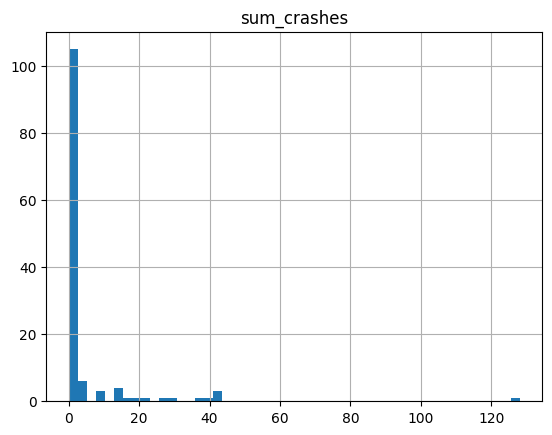

In [27]:
tims_proj_gdf.hist(column='sum_crashes', bins=50)